In [1]:
from tqdm.notebook import tqdm 
import time
c= 0
for i in tqdm(range(0,100)):
    c+=1
    # wait some time
    time.sleep(0.1)



  0%|          | 0/100 [00:00<?, ?it/s]

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

def output_size_calc(Input, Kernel, Stride, Padding):
    return (Input - Kernel + 2 * Padding) // Stride + 1


class Autoencoder(nn.Module):
    def __init__(self, kernel_size=3, latent_dim=128):
        super(Autoencoder, self).__init__()
        padding = kernel_size // 2  # preserve spatial size

        # Encoder: conv layers followed by flatten + linear layer
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=kernel_size, stride=2, padding=padding),   # 64×64 → 32×32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=2, padding=padding),  # 32×32 → 16×16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=kernel_size, stride=2, padding=padding), # 16×16 → 8×8
            nn.ReLU(),
            nn.Flatten(),                                                           # [B, 128*8*8]
            nn.Linear(128 * 8 * 8, latent_dim)                                      # → [B, latent_dim]
        )

        # Decoder: linear + reshape followed by conv transpose layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),                                     # [B, latent_dim] → [B, 8192]
            nn.Unflatten(1, (128, 8, 8)),                                           # → [B, 128, 8, 8]
            nn.ConvTranspose2d(128, 64, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1),  # 8×8 → 16×16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1),   # 16×16 → 32×32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1),    # 32×32 → 64×64
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out




# Initialize the autoencoder
model = Autoencoder(kernel_size=3)

# model_medium_kernel = Autoencoder(kernel_size=6)

# model_large_kernel = Autoencoder(kernel_size=10)

# print(f"Output size for each is : {output_size_calc(64, 3, 2, 1)}, {output_size_calc(64, 8, 2, 1)}, {output_size_calc(64, 16, 2, 1)}")




# Define transform
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
# Load dataset
train_dataset = datasets.Flowers102(root='flowers', 
                                    split='train', 
                                    transform=transform, 
                                    download=True)

test_dataset = datasets.Flowers102(root='flowers', 
                                   split='test', 
                                   transform=transform)
# Define the dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=128, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=128)


# Move the model to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# model.to(device)

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
# use the cpu
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda:3


1


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0700
Epoch [6/10], Loss: 0.0437


<Figure size 1600x1200 with 0 Axes>

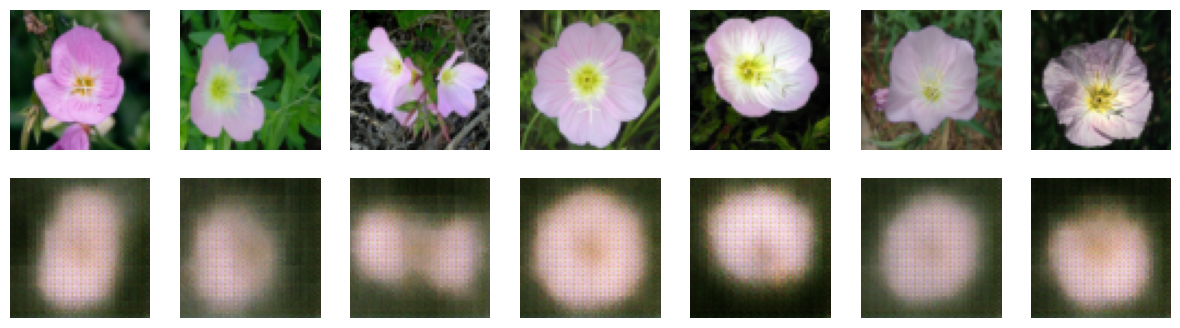

In [2]:
from tqdm.notebook import tqdm  # Use notebook-friendly tqdm
count = 0
names = ["small", "medium", "large"]
# print(model)
# Move the model to GPU
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Train the autoencoder
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

^10

Below = 20

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0320
Epoch [6/10], Loss: 0.0266


<Figure size 1600x1200 with 0 Axes>

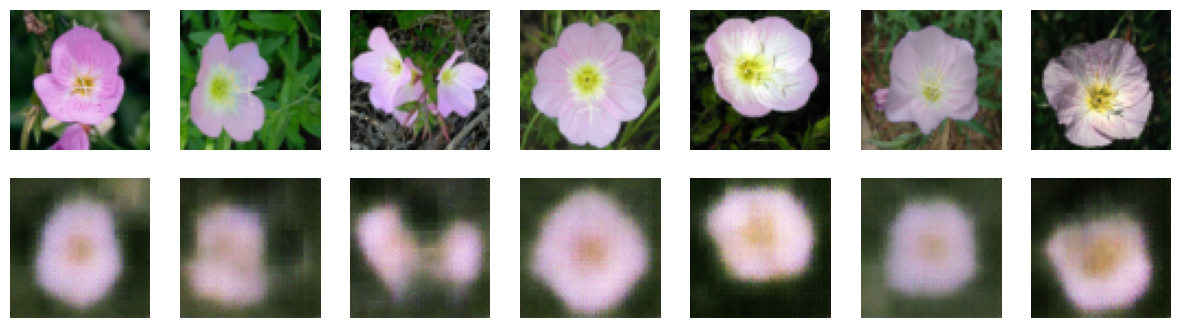

In [3]:
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

30

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0234
Epoch [6/10], Loss: 0.0190


<Figure size 1600x1200 with 0 Axes>

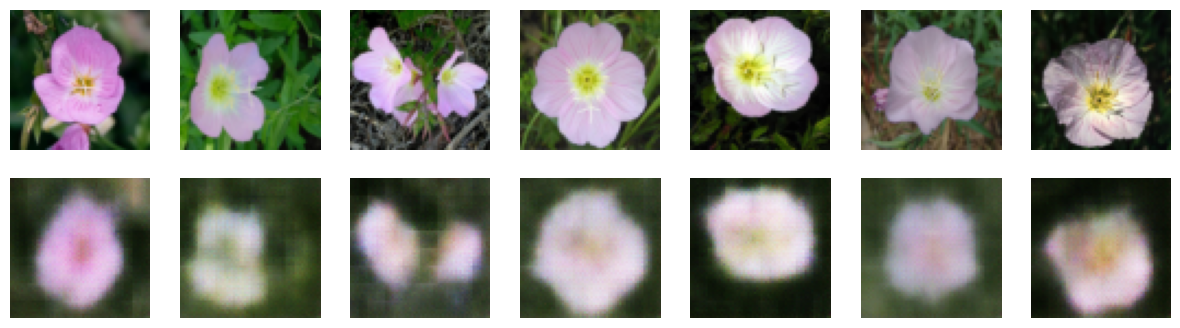

In [4]:
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

40

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0177
Epoch [6/10], Loss: 0.0170


<Figure size 1600x1200 with 0 Axes>

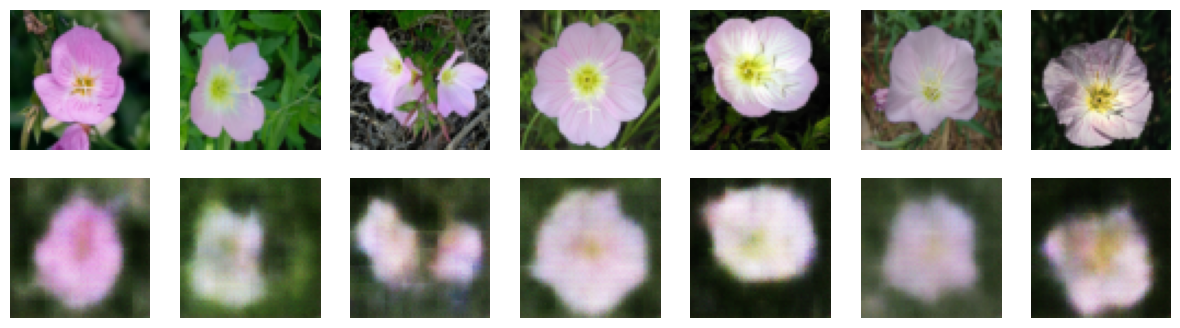

In [5]:
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

50

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0146
Epoch [6/10], Loss: 0.0129


<Figure size 1600x1200 with 0 Axes>

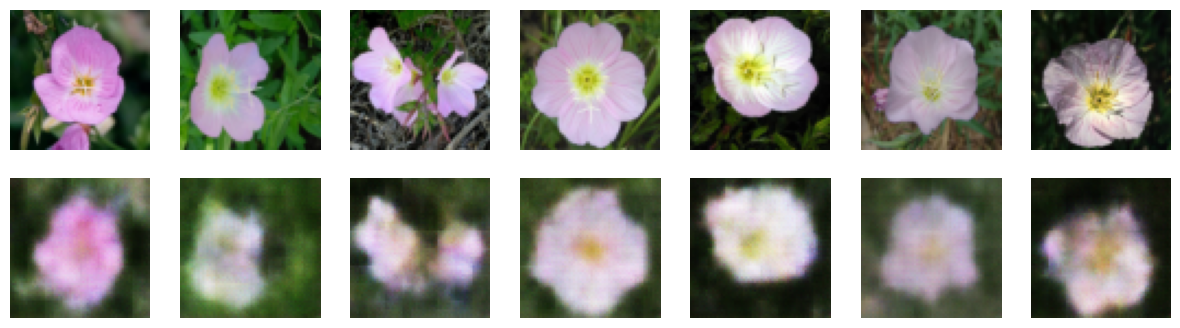

In [6]:
num_epochs = 10
for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    
    if epoch % 5 == 0:
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon = model(data)
        break
        
import matplotlib.pyplot as plt
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

Variational

In [5]:
2**10

1024

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, kernel_size=3, latent_dim=1024):
        super(VAE, self).__init__()
        padding = kernel_size // 2

        # Encoder: for 1-channel grayscale input (e.g., MNIST)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=kernel_size, stride=2, padding=padding),  # 28×28 → 14×14
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=kernel_size, stride=2, padding=padding), # 14×14 → 7×7
            nn.GELU(),
            nn.Flatten(),                                                          # [B, 64×7×7]
        )
        self.fc_mu_logvar = nn.Linear(64 * 7 * 7, latent_dim * 2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 7 * 7),
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1),  # 7×7 → 14×14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=kernel_size, stride=2, padding=padding, output_padding=1),   # 14×14 → 28×28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        mu_logvar = self.fc_mu_logvar(x)
        mu, logvar = torch.chunk(mu_logvar, 2, dim=1)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        out = self.decoder(z)
        return out, mu, logvar


In [3]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='mnist_data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='mnist_data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


# =======================
# Device Setup
# =======================
model = VAE(kernel_size=3, latent_dim=32)


device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# =======================
# Optimizer and Loss Function
# =======================
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use reduction='mean' for comparable loss scale
def vae_loss(recon, x, mu, logvar):
    # Per-image MSE (batch-wise mean of per-sample MSEs)
    recon_error = F.mse_loss(recon.view(recon.size(0), -1), x.view(x.size(0), -1), reduction='none')
    recon_error = recon_error.mean(dim=1)  # mean over pixels
    recon_loss = recon_error.mean()        # mean over batch

    # KL divergence (batch-wise mean)
    kl_div = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return recon_loss + kl_div







Using device: cuda:3


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Loss: 0.081644
Epoch [3/100], Loss: 0.067831
Epoch [5/100], Loss: 0.067571
Epoch [7/100], Loss: 0.067470
Epoch [9/100], Loss: 0.067412
Epoch [11/100], Loss: 0.067371
Early stopping triggered at epoch 12 (Δ < 0.1% over last 5 epochs)


<Figure size 1600x1200 with 0 Axes>

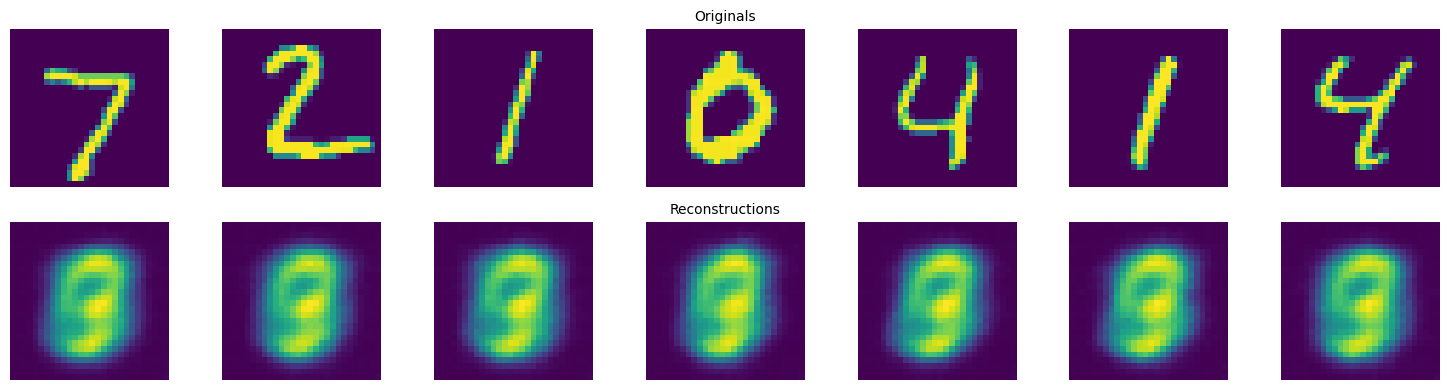

<Figure size 960x720 with 0 Axes>

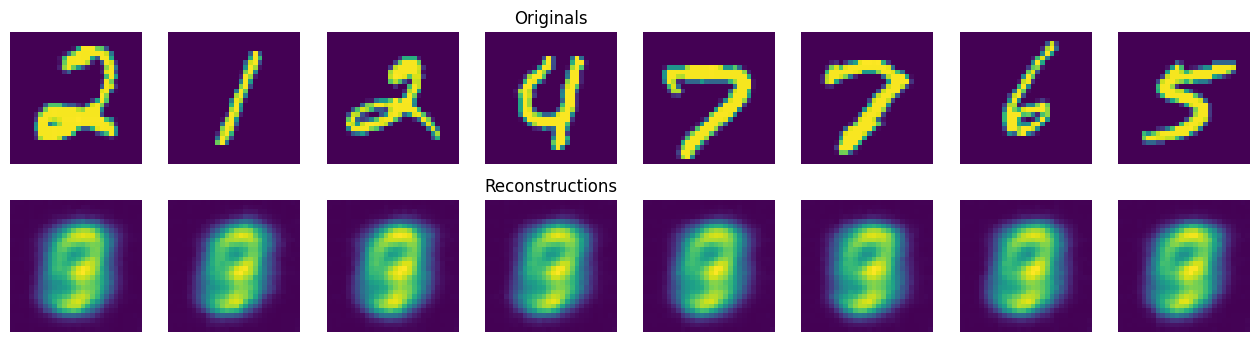

ValueError: x and y must have same first dimension, but have shapes (100,) and (12,)

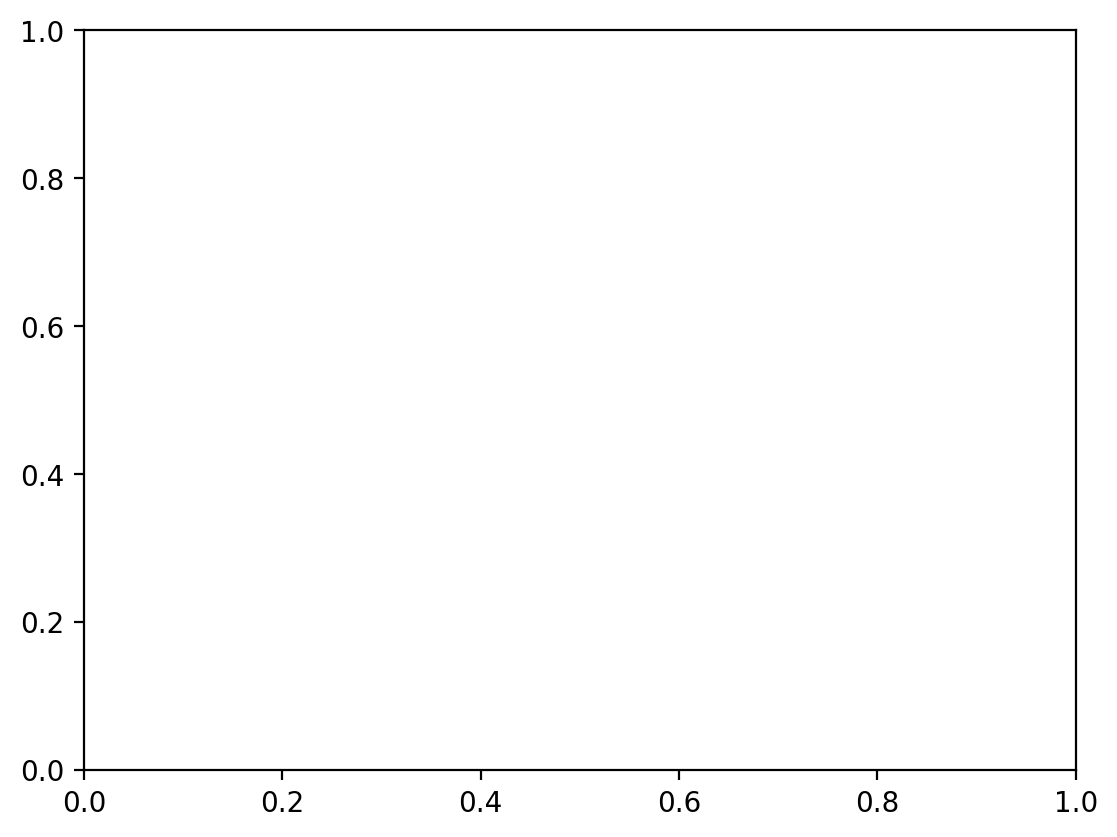

In [4]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
# =======================
# Training Loop with Early Stopping
# =======================
num_epochs = 100
train_losses = []
patience = 5  # number of epochs to check for minimal improvement
threshold = 0.001  # 1% threshold

model.train()
for epoch in tqdm(range(num_epochs), desc="Epochs", position=0):
    epoch_loss = 0
    for img, _ in train_loader:
        img = img.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(img)
        loss = vae_loss(recon, img, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    if epoch % 2 == 0 or epoch == num_epochs - 1:
        tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    # ---- Early stopping logic ----
    if len(train_losses) >= patience:
        recent_losses = train_losses[-patience:]
        max_diff = max(recent_losses) - min(recent_losses)
        pct_change = max_diff / max(recent_losses)
        if pct_change < threshold:
            tqdm.write(f"Early stopping triggered at epoch {epoch+1} (Δ < {threshold*100:.1f}% over last {patience} epochs)")
            break

# =======================
# Evaluation and Reconstruction on Test Set
# =======================
model.eval()
with torch.no_grad():
    for test_imgs, _ in test_loader:
        test_imgs = test_imgs.to(device)
        test_recons, _, _ = model(test_imgs)
        break  # Just one batch

# =======================
# Evaluation and Reconstruction on Train Set
# =======================
with torch.no_grad():
    for train_imgs, _ in train_loader:
        train_imgs = train_imgs.to(device)
        recons, _, _ = model(train_imgs)
        break  # Just one batch

# =======================
# Plot Test Originals vs Reconstructions
# =======================
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
for i in range(7):
    ax[0, i].imshow(test_imgs[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(test_recons[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 3].set_title("Originals", fontsize=10)
ax[1, 3].set_title("Reconstructions", fontsize=10)
plt.tight_layout()
plt.show()

# =======================
# Plot Train Reconstructions
# =======================
plt.figure(dpi=150)
fig, ax = plt.subplots(2, 8, figsize=(16, 4))
for i in range(8):
    ax[0, i].imshow(train_imgs[i].cpu().permute(1, 2, 0))
    ax[1, i].imshow(recons[i].cpu().permute(1, 2, 0))
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 3].set_title("Originals")
ax[1, 3].set_title("Reconstructions")
plt.show()

# =======================
# Plot Loss Curve
# =======================
plt.figure(dpi=200)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("VAE Training Loss Curve")
plt.grid(True)
plt.show()



One from https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid     

In [2]:
# create a transofrm to apply to each datapoint
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Using device: cuda:3


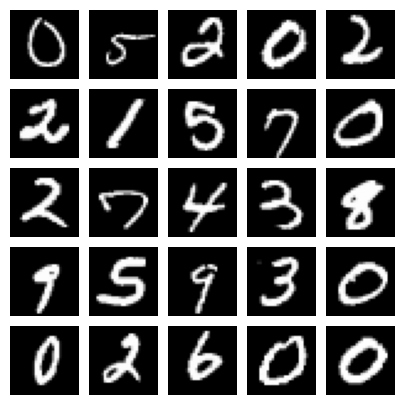

In [3]:
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i, 0] for i in range(num_samples)]  # single channel

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()


In [33]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [34]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [35]:

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [36]:
from tqdm.notebook import tqdm
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in tqdm(range(epochs)):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx * x.size(0)))
    return overall_loss

train(model, optimizer, epochs=20, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch 1 	Average Loss:  177.87499567964838
	Epoch 2 	Average Loss:  157.05104340567613
	Epoch 3 	Average Loss:  152.6890340508921
	Epoch 4 	Average Loss:  150.37762245343802
	Epoch 5 	Average Loss:  148.5591566999687
	Epoch 6 	Average Loss:  147.19818828907555
	Epoch 7 	Average Loss:  145.83230295935934
	Epoch 8 	Average Loss:  145.01406253260643
	Epoch 9 	Average Loss:  144.04077047357575
	Epoch 10 	Average Loss:  143.43671203307596
	Epoch 11 	Average Loss:  142.65628071525458
	Epoch 12 	Average Loss:  142.08731670296848
	Epoch 13 	Average Loss:  141.8685440741079
	Epoch 14 	Average Loss:  141.15815454142322
	Epoch 15 	Average Loss:  140.86729826403382
	Epoch 16 	Average Loss:  140.4989463885121
	Epoch 17 	Average Loss:  140.14274149950438
	Epoch 18 	Average Loss:  139.6707478773216
	Epoch 19 	Average Loss:  139.5493651202525
	Epoch 20 	Average Loss:  139.14791098771389


8334959.8681640625

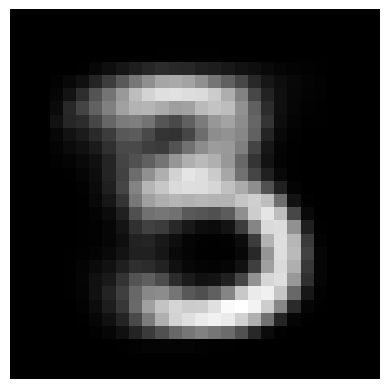

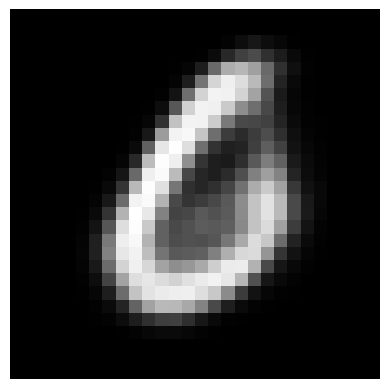

(None, None)

In [37]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

In [38]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

/tmp/ipykernel_570312/1901758076.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


Convolutional

In [6]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, device=device):
        super(VAE, self).__init__()
        self.device = device

        # Convolutional Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),   # 28x28 → 14x14
            nn.LeakyReLU(0.2),
            nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),  # 14x14 → 7x7
            nn.LeakyReLU(0.2),
            nn.Flatten(),                                          # [B, 16×7×7]
        )
        self.fc = nn.Linear(16 * 7 * 7, 200)
        self.mean_layer = nn.Linear(200, latent_dim)
        self.logvar_layer = nn.Linear(200, latent_dim)

        # Decoder: FC → ConvTranspose
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 200),
            nn.LeakyReLU(0.2),
            nn.Linear(200, 16 * 7 * 7),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (16, 7, 7)),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7x7 → 14x14
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),   # 14x14 → 28x28
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(self.device)
        return mean + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


In [7]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

from tqdm.notebook import tqdm
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in tqdm(range(epochs)):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(x.size(0), -1).to(device)  # FIXED: dynamically flatten input

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx * x.size(0)))
    return overall_loss

train(model, optimizer, epochs=20, device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch 1 	Average Loss:  196.9491251532502
	Epoch 2 	Average Loss:  156.73952657097766
	Epoch 3 	Average Loss:  150.61102677639818
	Epoch 4 	Average Loss:  147.89422848301857
	Epoch 5 	Average Loss:  145.95102783610704
	Epoch 6 	Average Loss:  144.60811769616026
	Epoch 7 	Average Loss:  143.53728207494262
	Epoch 8 	Average Loss:  142.50920295218594
	Epoch 9 	Average Loss:  141.6622494196056
	Epoch 10 	Average Loss:  140.99554346762835
	Epoch 11 	Average Loss:  140.40732723484453
	Epoch 12 	Average Loss:  139.70457238300813
	Epoch 13 	Average Loss:  139.3068857275146
	Epoch 14 	Average Loss:  138.75228274337437
	Epoch 15 	Average Loss:  138.45313884142843
	Epoch 16 	Average Loss:  137.89375242917885
	Epoch 17 	Average Loss:  137.54862762807804
	Epoch 18 	Average Loss:  137.0822761079664
	Epoch 19 	Average Loss:  136.7303576435987
	Epoch 20 	Average Loss:  136.44735953151084


8173196.8359375

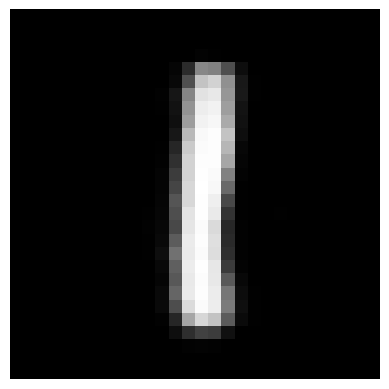

(None, None)

In [8]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decode(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

/tmp/ipykernel_612244/1901758076.py:14: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit


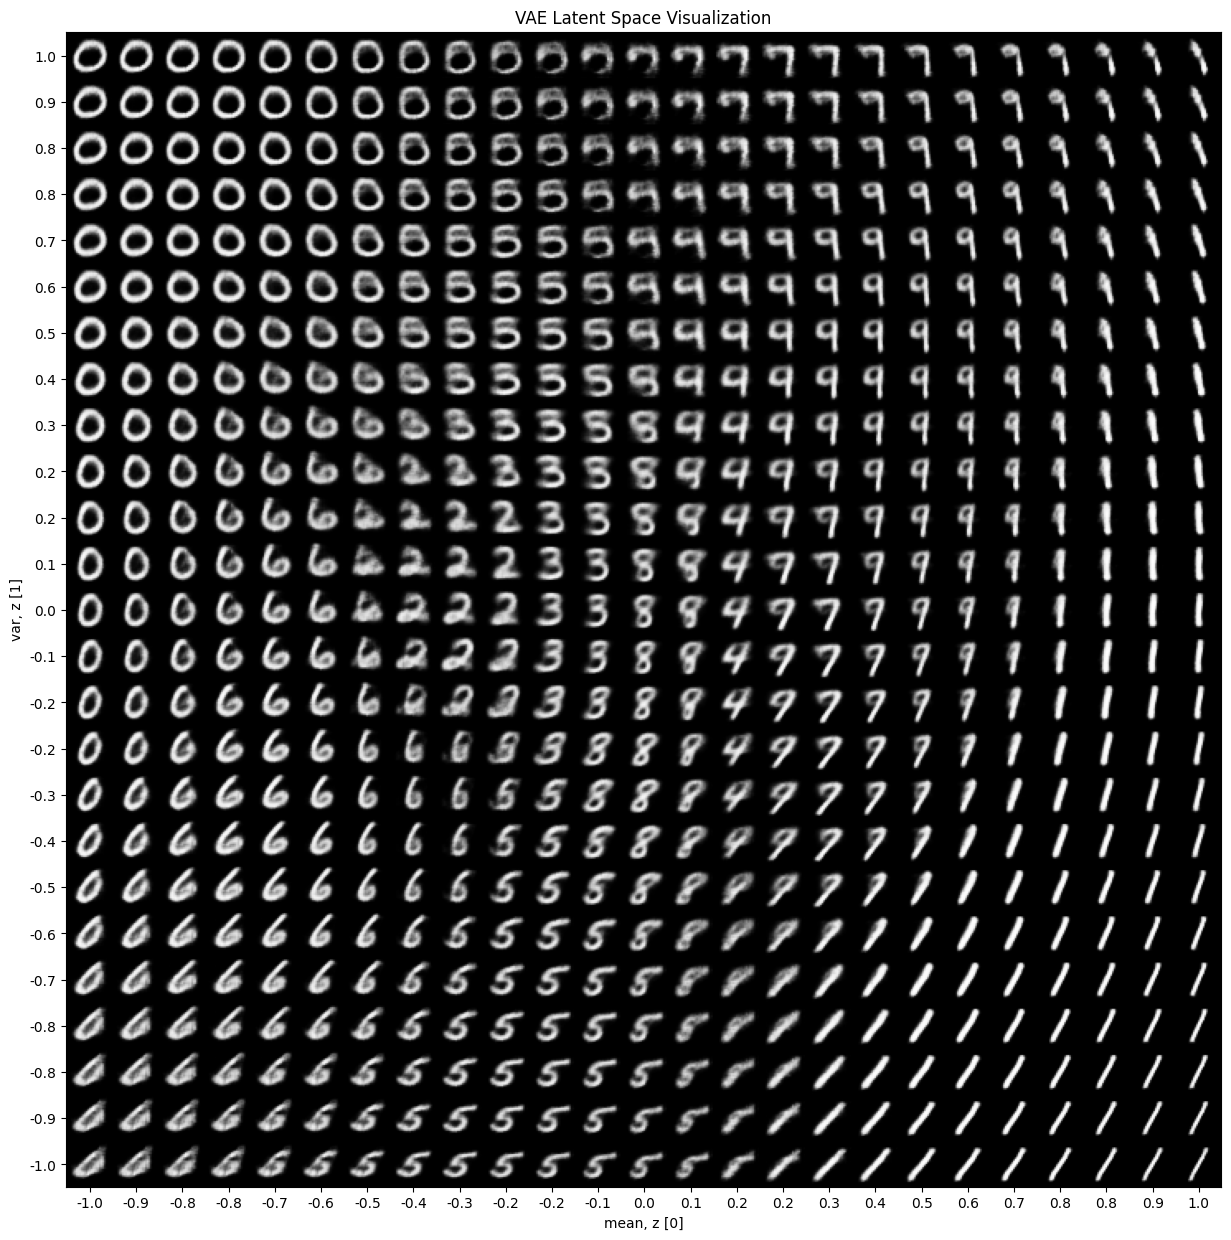

In [9]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decode(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)